In [1]:
from osgeo import gdal
import sklearn as sk
import dice
import input_test_inter
import numpy as np
import tensorflow as tf
import time
import os
from sklearn.metrics import confusion_matrix

In [2]:
%matplotlib 
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

/home/gitecx/anaconda2/envs/tensorflow/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Using matplotlib backend: Qt4Agg


In [3]:
# ./modelos_clases_4/model_B_7_c1_128_c2_256_fc_1024_learning_rate_1e-06_dropout_0.5_decay_0.9_epsilon_1e-08_Bathsize_100.ckpt
batch_size = int(51243/100)
dropout = 0.5
n_classes = 4
epsilon=1e-08
epochs=11
c1=128
c2=256
fc=1024
b1=128
b2=256
b3=1024
decay=0.9
bands=6
epsilon=1e-08
learning_rate = 1e-05

# learning_rate_1e-05_dropout_0.5_decay_0.9_epsilon_1e-08_Bathsize_392.ckpt

In [4]:
dataset= input_test_inter.read_data_sets("/media/gitecx/Nuevo vol/ASIAlac/Patch/Clases_TOA/Entrenamiento",
                                   "/media/gitecx/Nuevo vol/ASIAlac/Patch/Clases_TOA/Validacion_2",
                                   bands,n_clases=n_classes,mi=False)


No normalizado
No normalizado
51243
5692
No normalizado
21584


In [5]:
def conv2d(img, w, b):
    return tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(img, w, strides=[1, 1, 1, 1], padding='VALID'),b))

def max_pool(img):
    return tf.nn.max_pool(img, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

def conv_net2(images,w,b,_dropout):
    # Conv 1
    conv1 = conv2d(images,w['wc1'], b['bc1'])    
    # Max Pooling (down-sampling)
    conv1 = max_pool(conv1)
    # Apply Dropout
    conv1 = tf.nn.dropout(conv1, _dropout)
    
    #Conv 2
    conv2 = conv2d(conv1, w['wc2'], b['bc2'])
    # Max Pooling (down-sampling)
    conv2 = max_pool(conv2)
    
    # Apply Dropout
    conv2 = tf.nn.dropout(conv2, _dropout)

    # Fully connected layer
    # Reshape conv2 output to fit dense layer input
    dense1 = tf.reshape(conv2, [-1, w['wd1'].get_shape().as_list()[0]]) 
        
    # Relu activation
    dense1 = tf.nn.relu(tf.add(tf.matmul(dense1, w['wd1']),b['bd1']))
    # Apply Dropout
    dense1 = tf.nn.dropout(dense1, _dropout) # Apply Dropout

    # Output, class prediction
    out = tf.add(tf.matmul(dense1, w['out']),b['out'])
    return out


In [6]:
keep_prob = tf.placeholder(tf.float32) 
# tf Graph input
x = tf.placeholder(tf.float32,[None,20,20,bands])
y = tf.placeholder("float", [None, n_classes])
  
    
    

weights = {  
   # 5x5 conv, 7 input, 128 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, bands, c1])), 
     # 5x5 conv, 128 inputs, 256 outputs
    'wc2': tf.Variable(tf.random_normal([5, 5, c1, c2])), 
    # fully connected, 7*7*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([2*2*c2, fc])), 
        # 1024 inputs, 10 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([fc, n_classes])) 
}

biases = {
    'bc1': tf.Variable(tf.random_normal([b1])),
    'bc2': tf.Variable(tf.random_normal([b2])),
    'bd1': tf.Variable(tf.random_normal([b3])),
    'out': tf.Variable(tf.random_normal([n_classes]))
    }
saver = tf.train.Saver()

pred = conv_net2(x,weights,biases, keep_prob) 
prediction  = tf.argmax(pred,1)  
    
# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=decay,  epsilon=epsilon).minimize(cost)
#optimizer =tf.train.AdadeltaOptimizer(learning_rate=learning_rate,rho=decay, epsilon=1e-08).minimize(cost)
# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
# Initializing the variables
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [7]:
def accuracy2(path,size,select):
    position=[]
    if select==True:
        matrix = test_model(path,size)
    else:
        matrix,position = validation_model(path,size)
        
        
    labels= ["Bosques",
         "Areas con vegetacion herbacea y,o arbustiva",
         "Areas abiertas, sin o con poca vegetacion","Aguas continentales"]
    import seaborn as sns; sns.set()
    f, ax = plt.subplots(figsize=(15, 8))
    ax = sns.heatmap(matrix,annot=True,linewidths=.5,cmap=plt.cm.coolwarm, xticklabels=labels, yticklabels=labels)
    f.tight_layout()
    return position

def folders(model,ep):

    path, filename = os.path.split(model)        
    directory = os.path.join(path,ep)
    if not os.path.exists(directory):
        os.makedirs(directory)
        
    return directory
    

In [8]:
def continue_training (model_path,size, size_text, ep):
    from sklearn.metrics import confusion_matrix
    with tf.Session() as sess :
        saver.restore(sess,model_path)
        print ("Model successfully restored")
        
#####################################################
#### Continue Training
#####################################################
        flimit=(39279/batch_size)*epochs
    
        for i in range (1,flimit+1):
            
            batch_xs, batch_ys ,_= dataset.train.next_batch(batch_size)
            # Fit training using batch data
            start_time = time.clock()
            sess.run(optimizer, feed_dict={x: batch_xs, y: batch_ys, keep_prob: dropout})
        
            if( i%int(size/batch_size)==0):
            
                epoch_time = time.clock()
                print "time this epoch=", (epoch_time-start_time)
                correct2 =0

                step = 1
                y_true_a = 0
                y_pred_a = 0
                limit = size_text/batch_size
            
######################################################
###   Continue_Testing 
######################################################
                while step <= limit:
                    t_batch_xs, t_batch_ys,_ = dataset.test.next_batch(batch_size)

                    
                    y_true = np.argmax(t_batch_ys,1)

                    labels = prediction.eval(feed_dict={x: t_batch_xs, y: t_batch_ys,
                                                        keep_prob: 1.}, session=sess)    
                    
                    if (step ==1):
                        y_true_a+=y_true
                        y_pred_a+=labels              
                    else:
                        y_true_a = np.concatenate((y_true_a, y_true))
                        y_pred_a = np.concatenate((y_pred_a, labels))
                    step+=1

        
                a=confusion_matrix(y_true_a, y_pred_a)            
                
                accuaracy,matrix=precision_measure(a)
                print ("test accuracy "+str(accuaracy))

        np.set_printoptions(precision=3, suppress=True)
        print (a)
        print (matrix)
        kk="TOA"+"_"+str(ep)
        model = os.path.join(folders(model_path,str(ep)),kk)
        variables ="B_" + str(bands) + "_c1_"+str(c1)+"_c2_"+str(c2)+"_fc_"+str(fc)+"_learning_rate_"+str(learning_rate)+"_dropout_"+str(dropout)+"_decay_"+str(decay)+"_epsilon_"+str(epsilon)+"_bath_"+str(batch_size)+"_ep_"+str(ep)+".ckpt"
        save_path = saver.save(sess, model)
        print "model saved as {}".format(model)
        print "variables saved {}".format(variables)
        

        
        sess.close()

In [9]:
def precision_measure (a2):
    pro=0
    b2=a2.astype(float)

    for i in range(n_classes):
        a1=b2[i]
        sum_a1=np.sum(b2[i])
        if(sum_a1 > 0):
            b2[i]=a1/sum_a1
    #print ('Matrix de confusion con medidas de desempeño')
    np.set_printoptions(precision=3)
    for l in range (n_classes):
        if(b2[l][l]!=np.nan):
            pro+=b2[l][l]
        
    pro=pro/n_classes 
    return pro,b2

In [10]:
def test_model(model_path, size=8410):
    with tf.Session() as sess:
        saver.restore(sess,model_path)
        print ("Model successfully restored")
    
        step = 1
        y_true_a = 0
        y_pred_a = 0
        limit = size/100
######################################################
###   Test 
######################################################
        while step <= limit:
            t_batch_xs, t_batch_ys,_= dataset.test.next_batch(batch_size)

            y_true = np.argmax(t_batch_ys,1)
            labels = prediction.eval(feed_dict={x: t_batch_xs, y: t_batch_ys, keep_prob: 1.}, session=sess)    
            if (step ==1):
                y_true_a+=y_true
                y_pred_a+=labels              
            else:
                y_true_a = np.concatenate((y_true_a, y_true))
                y_pred_a = np.concatenate((y_pred_a, labels))
            step+=1

        a=confusion_matrix(y_true_a, y_pred_a)            
        print ("sklearn martix")
        accuaracy,matrix=precision_measure(a)
        
        print ("test accuracy "+str(accuaracy))
        np.set_printoptions(precision=3, suppress=True)
        print (matrix)
        sess.close()
    return matrix

In [11]:
def validation_model(model_path, size=8410):
    with tf.Session() as sess:
        saver.restore(sess,model_path)
        print ("Model successfully restored")

        step = 1
        y_true_a = 0
        y_pred_a = 0
        limit = size/100
        posicion=[]
######################################################
###   Test 
######################################################
        while step < limit:
            t_batch_xs, t_batch_ys,p = dataset.validation.next_batch(batch_size)

            y_true = np.argmax(t_batch_ys,1)
            pred_1 = prediction.eval(feed_dict={x: t_batch_xs, y: t_batch_ys, keep_prob: 1.}, session=sess)    
            if (step ==1):
                y_true_a+=y_true
                y_pred_a+=pred_1              
            else:
                y_true_a = np.concatenate((y_true_a, y_true))
                y_pred_a = np.concatenate((y_pred_a, pred_1))
            step+=1
            
            for i in range(len(p)):
                xi=p[i].find('x=')
                
                xi=p[i].find('x=')
                yi=p[i].find('y=')
                z=p[i].find('Size')
                x0=p[i][xi+2:yi-1]
                y0=p[i][yi+2:z]

                posicion.append([[x0],[y0],pred_1[i]])
           
        a=confusion_matrix(y_true_a, y_pred_a)            
        print ("sklearn martix")
        print (a)
                       
        accuaracy,matrix=precision_measure(a)
        print ("test accuracy "+str(accuaracy))
        np.set_printoptions(precision=3, suppress=True)        
        print (matrix)
        sess.close()
    return matrix,posicion

In [12]:
from sklearn.metrics import confusion_matrix
with tf.Session() as sess:
    sess.run(init)
    print ("Start Train")     
    
# 51243
# 5692
# 21278


##########################################################            
###   TRAIN
##########################################################
    flimit=(51243/batch_size)*epochs
 
    for i in range (1,flimit+1):
        
        batch_xs, batch_ys,_ = dataset.train.next_batch(batch_size)
        # Fit training using batch data

        start_time = time.clock()
        sess.run(optimizer, feed_dict={x: batch_xs, y: batch_ys, keep_prob: dropout})
        
        if(i%int(51243/batch_size)==0):
            
            epoch_time = time.clock()
            print "time this epoch=", (epoch_time-start_time)
            correct2 =0
            y_p = tf.argmax(pred,1)
            step = 1
            y_true_a = 0
            y_pred_a = 0
            limit = 5692/100
######################################################
###   Test 
######################################################
            while step <= limit:
        
                t_batch_xs, t_batch_ys,_= dataset.test.next_batch(batch_size)
                y_true = np.argmax(t_batch_ys,1)
                labels = prediction.eval(feed_dict={x: t_batch_xs, y: t_batch_ys, keep_prob: 1.}, session=sess)    
                
                if (step ==1):
                    y_true_a+=y_true
                    y_pred_a+=labels              
                else:
                    y_true_a = np.concatenate((y_true_a, y_true))
                    y_pred_a = np.concatenate((y_pred_a, labels))
                step+=1

            a=confusion_matrix(y_true_a, y_pred_a)            
            accuaracy,matrix=precision_measure(a)
            print ("test accuracy "+str(accuaracy))
            
#######################################################   
#   END TRAIN             
############################

    print "Optimization Finished!"    
    model= "/media/gitecx/Nuevo vol/ASIAlac/Modelos/borrar/TOA.ckpt" 
    variables = "B_" + str(bands) + "_c1_"+str(c1)+"_c2_"+str(c2)+"_fc_"+str(fc)+"_learning_rate_"+str(learning_rate)+"_dropout_"+str(dropout)+"_decay_"+str(decay)+"_epsilon_"+str(epsilon)+"_Bathsize_"+str(batch_size)+".ckpt"
    
    np.set_printoptions(precision=3, suppress=True)
    print (a)
    print (matrix)
    save_path = saver.save(sess, model)
    print("Model saved in file: %s" % save_path)
    print("Model variables : %s" % variables)
    sess.close()        
        

Start Train
time this epoch= 0.096827
test accuracy 0.333792252059
time this epoch= 0.099536
test accuracy 0.351648942148
time this epoch= 0.098923
test accuracy 0.380193494786
time this epoch= 0.097242
test accuracy 0.417178410338
time this epoch= 0.10146
test accuracy 0.426799965082
time this epoch= 0.100647
test accuracy 0.467703070274
time this epoch= 0.10406
test accuracy 0.562744715094
time this epoch= 0.100129
test accuracy 0.607949900361
time this epoch= 0.097444
test accuracy 0.629689873816
time this epoch= 0.105135
test accuracy 0.646365403955
time this epoch= 0.098762
test accuracy 0.66462626078
Optimization Finished!
[[5972 1111   84    0]
 [ 140 6777  246    0]
 [ 112 1062 6003    0]
 [1113 3633 2113  306]]
[[ 0.833  0.155  0.012  0.   ]
 [ 0.02   0.946  0.034  0.   ]
 [ 0.016  0.148  0.836  0.   ]
 [ 0.155  0.507  0.295  0.043]]
Model saved in file: /media/gitecx/Nuevo vol/ASIAlac/Modelos/borrar/TOA.ckpt
Model variables : B_6_c1_128_c2_256_fc_1024_learning_rate_1e-05_drop

# Prueba con los datos de entrenamiento las primeras 11 epocas

Model successfully restored
sklearn martix
test accuracy 0.654368504986
[[ 0.826  0.16   0.013  0.   ]
 [ 0.02   0.93   0.051  0.   ]
 [ 0.012  0.161  0.827  0.   ]
 [ 0.185  0.48   0.3    0.035]]


/home/gitecx/anaconda2/envs/tensorflow/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


[]

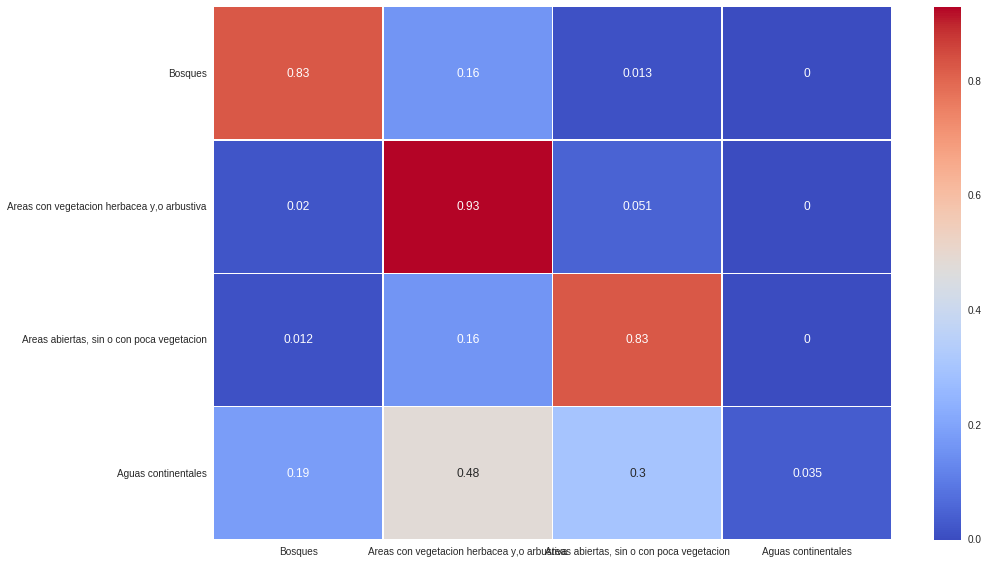

In [12]:
# 51243
# 5692
# 21278

accuracy2('/media/gitecx/Nuevo vol/ASIAlac/Modelos/borrar/TOA.ckpt',
          5692,True)


# Validacion Primeras 11 epocas

Model successfully restored
sklearn martix
[[64617   852   177     0]
 [ 1039 17190 22563     0]
 [    0   240  2497     0]
 [   15   172    66   140]]
test accuracy 0.668569505486
[[ 0.984  0.013  0.003  0.   ]
 [ 0.025  0.421  0.553  0.   ]
 [ 0.     0.088  0.912  0.   ]
 [ 0.038  0.438  0.168  0.356]]


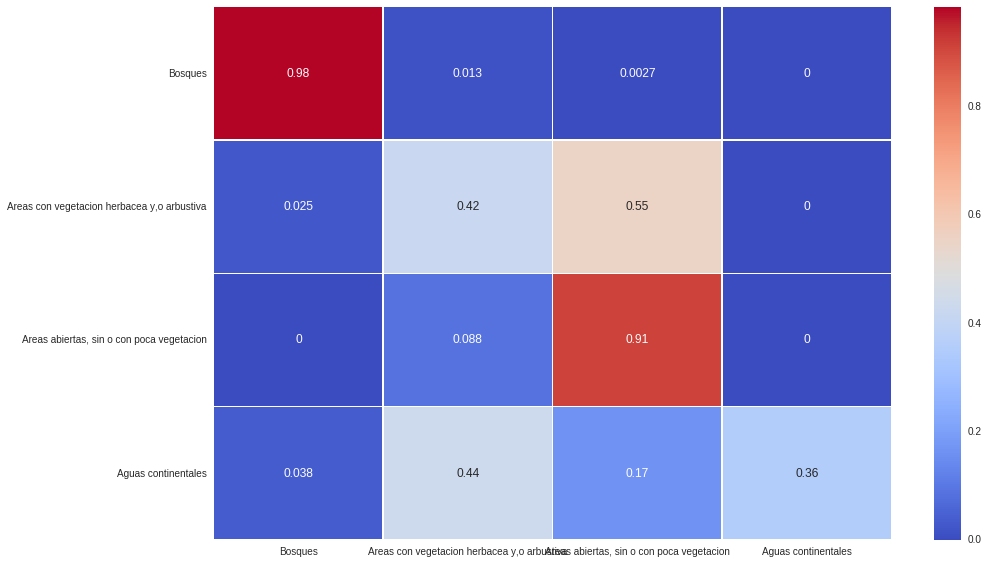

In [13]:
p=accuracy2("/media/gitecx/Nuevo vol/ASIAlac/Modelos/borrar/TOA.ckpt",
          21584,False)



# Restaurar modelos

## Redefinir variables

In [12]:
# 51243
# 5692
# 21278
continue_training('/media/gitecx/Nuevo vol/ASIAlac/Modelos/borrar/TOA.ckpt',
                  51243,5692,22)


Model successfully restored
time this epoch= 0.101569
test accuracy 0.672095210834
time this epoch= 0.100542
test accuracy 0.669062450553
time this epoch= 0.105977
test accuracy 0.667028409806
time this epoch= 0.101919
test accuracy 0.670818354315
time this epoch= 0.10417
test accuracy 0.671617340582
time this epoch= 0.099903
test accuracy 0.666675997074
time this epoch= 0.102317
test accuracy 0.675029994587
time this epoch= 0.104351
test accuracy 0.67352778731
[[1300   91   11    4]
 [  63 1071  273    0]
 [  39   91 1278    0]
 [ 316  401  552  142]]
[[ 0.925  0.065  0.008  0.003]
 [ 0.045  0.761  0.194  0.   ]
 [ 0.028  0.065  0.908  0.   ]
 [ 0.224  0.284  0.391  0.101]]
model saved as /media/gitecx/Nuevo vol/ASIAlac/Modelos/borrar/22/TOA_22
variables saved B_6_c1_128_c2_256_fc_1024_learning_rate_1e-05_dropout_0.5_decay_0.9_epsilon_1e-08_bath_512_ep_22.ckpt


Model successfully restored
sklearn martix
test accuracy 0.677182558854
[[ 0.926  0.064  0.008  0.003]
 [ 0.045  0.776  0.179  0.   ]
 [ 0.027  0.063  0.911  0.   ]
 [ 0.225  0.281  0.398  0.097]]


[]

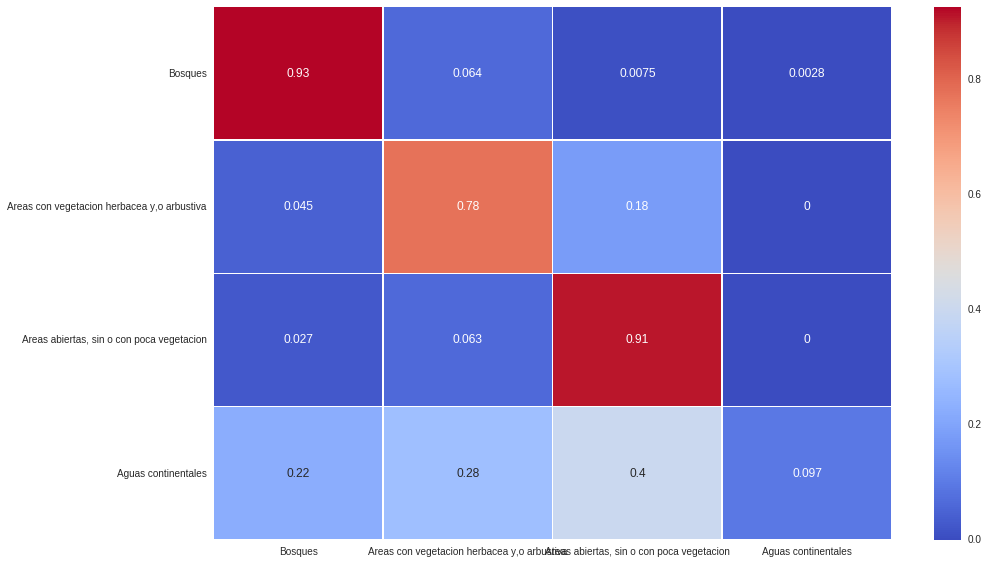

In [15]:
accuracy2('/media/gitecx/Nuevo vol/ASIAlac/Modelos/borrar/22/TOA_22',
          5692,True)


Model successfully restored
sklearn martix
[[65062   372   156     5]
 [ 1905  5869 33076     0]
 [    0    10  2716     0]
 [   88     0   123   186]]
test accuracy 0.650097956655
[[ 0.992  0.006  0.002  0.   ]
 [ 0.047  0.144  0.81   0.   ]
 [ 0.     0.004  0.996  0.   ]
 [ 0.222  0.     0.31   0.469]]


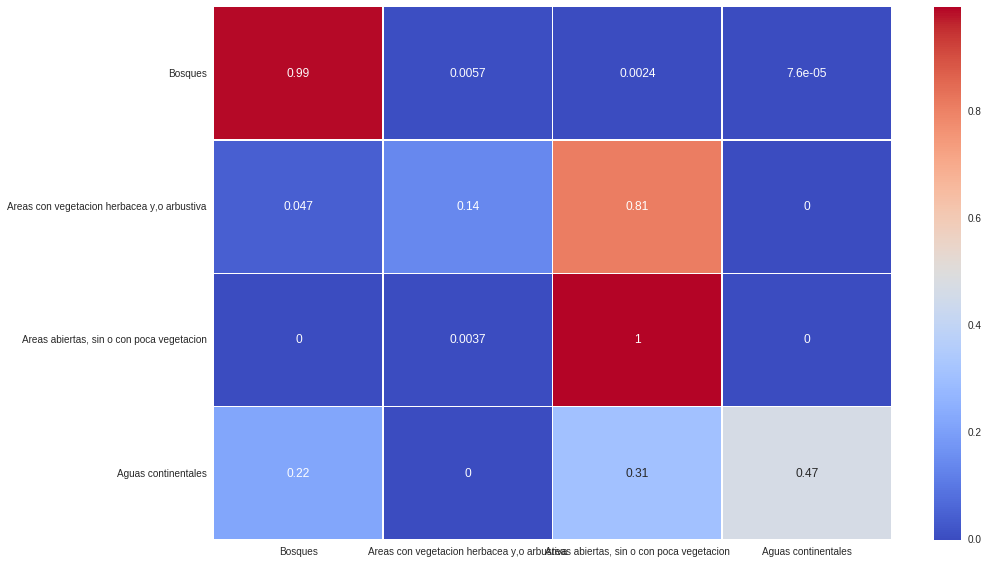

In [16]:
p=accuracy2('/media/gitecx/Nuevo vol/ASIAlac/Modelos/borrar/22/TOA_22',
          21584,False)


# Restaurar el modelo y continuar el entrenamiento

In [15]:
continue_training('/media/gitecx/Nuevo vol/ASIAlac/Modelos/borrar/22/TOA_22',
                  51243,5692,33)


Model successfully restored
time this epoch= 0.098419
test accuracy 0.722640737998
time this epoch= 0.097523
test accuracy 0.736795062901
time this epoch= 0.099404
test accuracy 0.752150416799
time this epoch= 0.097901
test accuracy 0.758742840192
time this epoch= 0.099369
test accuracy 0.756478948338
time this epoch= 0.099087
test accuracy 0.764193905857
time this epoch= 0.102661
test accuracy 0.768889896136
time this epoch= 0.09969
test accuracy 0.772357125906
[[1313   50   12   16]
 [  74 1217  129    0]
 [  37   73 1289    0]
 [ 254  297  349  522]]
[[ 0.944  0.036  0.009  0.012]
 [ 0.052  0.857  0.091  0.   ]
 [ 0.026  0.052  0.921  0.   ]
 [ 0.179  0.209  0.245  0.367]]
model saved as /media/gitecx/Nuevo vol/ASIAlac/Modelos/borrar/22/33/TOA_33
variables saved B_6_c1_128_c2_256_fc_1024_learning_rate_1e-05_dropout_0.75_decay_0.96_epsilon_1e-08_bath_512_ep_33.ckpt


Model successfully restored
sklearn martix
test accuracy 0.771194063515
[[ 0.94   0.038  0.009  0.013]
 [ 0.051  0.862  0.088  0.   ]
 [ 0.026  0.054  0.92   0.   ]
 [ 0.179  0.216  0.241  0.363]]


[]

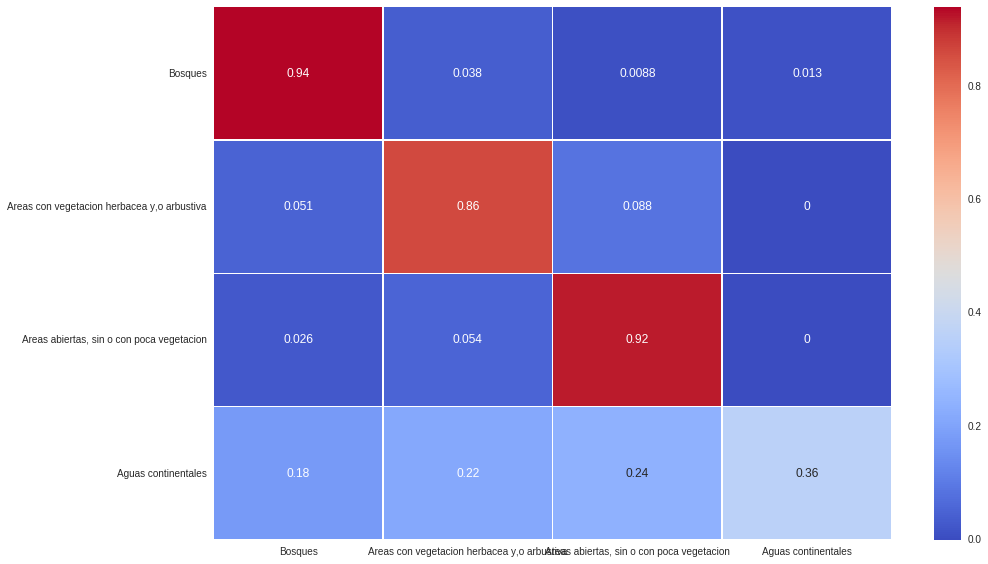

In [16]:
accuracy2('/media/gitecx/Nuevo vol/ASIAlac/Modelos/borrar/22/33/TOA_33',
          5692,True)

Model successfully restored
sklearn martix
[[65113   361    96    36]
 [ 2464  8959 29387    22]
 [    0    13  2722     0]
 [   61     0     0   334]]
test accuracy 0.763178277618
[[ 0.992  0.006  0.001  0.001]
 [ 0.06   0.219  0.72   0.001]
 [ 0.     0.005  0.995  0.   ]
 [ 0.154  0.     0.     0.846]]


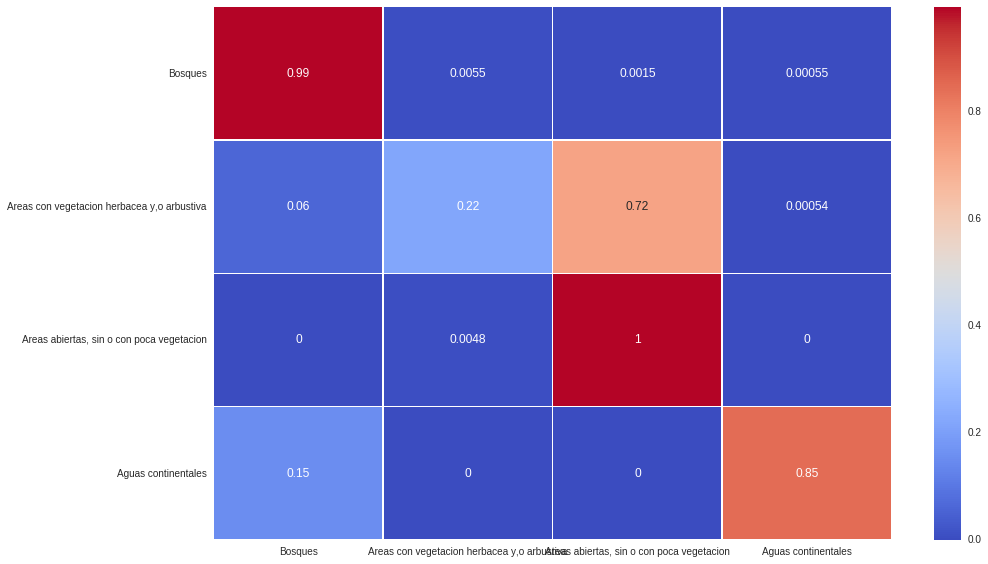

In [17]:
p=accuracy2('/media/gitecx/Nuevo vol/ASIAlac/Modelos/borrar/22/33/TOA_33',
          21584,False)

In [18]:
continue_training('/media/gitecx/Nuevo vol/ASIAlac/Modelos/borrar/22/33/TOA_33',
                  51243,5692,44)


Model successfully restored
time this epoch= 0.102543
test accuracy 0.769165747201
time this epoch= 0.097381
test accuracy 0.777895469578
time this epoch= 0.0983
test accuracy 0.77773248621
time this epoch= 0.096857
test accuracy 0.793276277806
time this epoch= 0.097809
test accuracy 0.784333774196
time this epoch= 0.097349
test accuracy 0.798618201887
time this epoch= 0.098105
test accuracy 0.7910660873
time this epoch= 0.100248
test accuracy 0.796589081346
[[1323   52    9   18]
 [  63 1273   82    0]
 [  32   74 1296    0]
 [ 252  272  293  593]]
[[ 0.944  0.037  0.006  0.013]
 [ 0.044  0.898  0.058  0.   ]
 [ 0.023  0.053  0.924  0.   ]
 [ 0.179  0.193  0.208  0.421]]
model saved as /media/gitecx/Nuevo vol/ASIAlac/Modelos/borrar/22/33/44/TOA_44
variables saved B_6_c1_128_c2_256_fc_1024_learning_rate_1e-05_dropout_0.75_decay_0.96_epsilon_1e-08_bath_512_ep_44.ckpt


Model successfully restored
sklearn martix
test accuracy 0.798695031548
[[ 0.94   0.04   0.008  0.012]
 [ 0.045  0.895  0.06   0.   ]
 [ 0.023  0.055  0.922  0.   ]
 [ 0.165  0.193  0.206  0.437]]


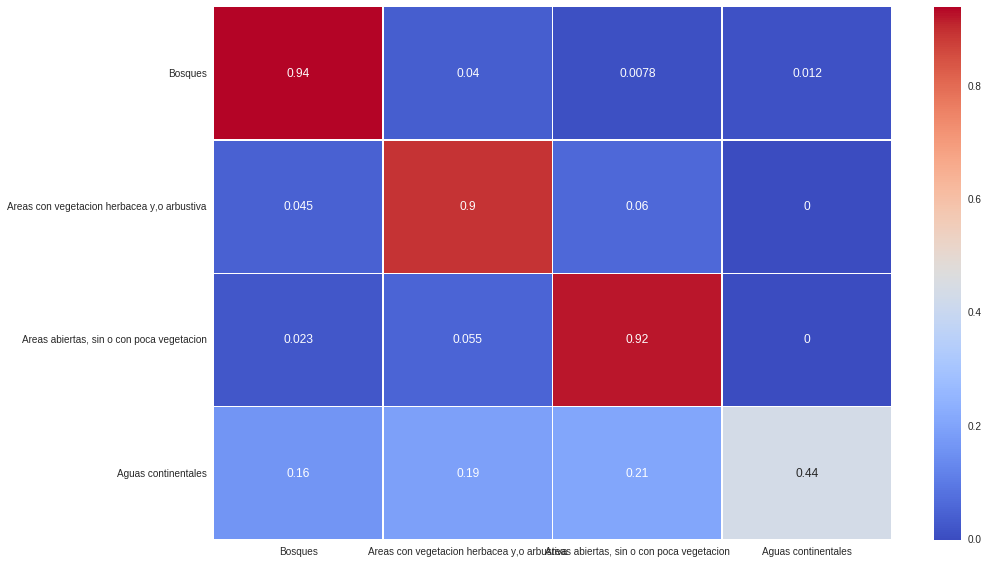

In [19]:
p=accuracy2('/media/gitecx/Nuevo vol/ASIAlac/Modelos/borrar/22/33/44/TOA_44',
            5692,True)

Model successfully restored
sklearn martix
[[65135   354    65    94]
 [ 2474 10617 27704    21]
 [    0    29  2678     0]
 [   62     0     0   335]]
test accuracy 0.771354981459
[[ 0.992  0.005  0.001  0.001]
 [ 0.061  0.26   0.679  0.001]
 [ 0.     0.011  0.989  0.   ]
 [ 0.156  0.     0.     0.844]]


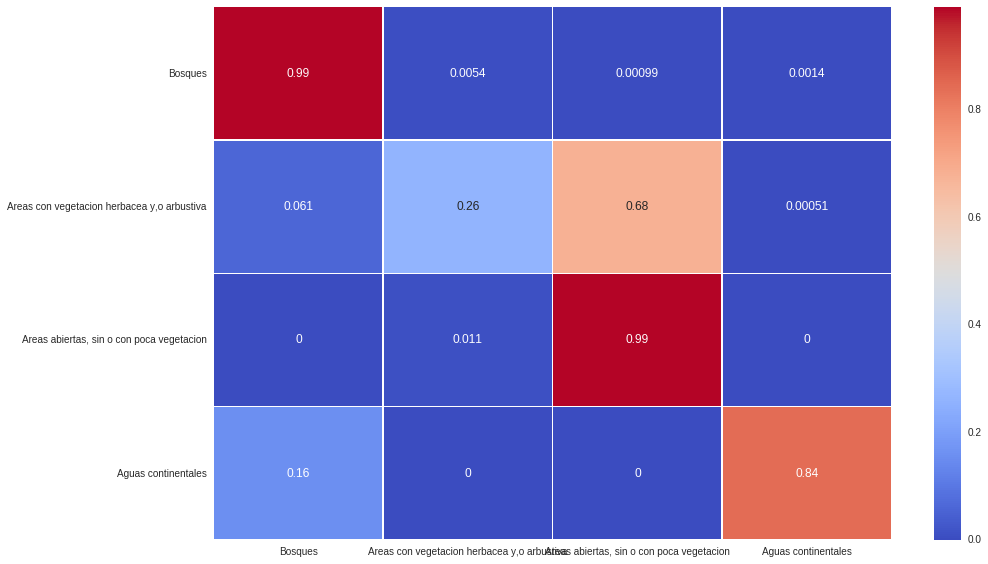

In [20]:
p=accuracy2('/media/gitecx/Nuevo vol/ASIAlac/Modelos/borrar/22/33/44/TOA_44',
            21584,False)

In [12]:
continue_training('/media/gitecx/Nuevo vol/ASIAlac/Modelos/borrar/22/33/44/TOA_44',
                  51243,5692,55)

Model successfully restored
time this epoch= 0.10848
test accuracy 0.862915472778
time this epoch= 0.101305
test accuracy 0.872501655024
time this epoch= 0.107306
test accuracy 0.87719236792
time this epoch= 0.10307
test accuracy 0.880782733396
time this epoch= 0.105617
test accuracy 0.885077730742
time this epoch= 0.105467
test accuracy 0.886919340697
time this epoch= 0.105311
test accuracy 0.887473123618
time this epoch= 0.100805
test accuracy 0.890765309472
[[1345   15    8   38]
 [  66 1254   68   19]
 [  60   59 1282   13]
 [  88   73  108 1136]]
[[ 0.957  0.011  0.006  0.027]
 [ 0.047  0.891  0.048  0.014]
 [ 0.042  0.042  0.907  0.009]
 [ 0.063  0.052  0.077  0.809]]
model saved as /media/gitecx/Nuevo vol/ASIAlac/Modelos/borrar/22/33/44/55/TOA_55
variables saved B_6_c1_128_c2_256_fc_1024_learning_rate_1e-05_dropout_0.75_decay_0.96_epsilon_1e-08_bath_512_ep_55.ckpt


Model successfully restored
sklearn martix
test accuracy 0.891852200168
[[ 0.955  0.011  0.006  0.027]
 [ 0.045  0.892  0.05   0.013]
 [ 0.042  0.041  0.908  0.009]
 [ 0.062  0.052  0.073  0.813]]


/home/gitecx/anaconda2/envs/tensorflow/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


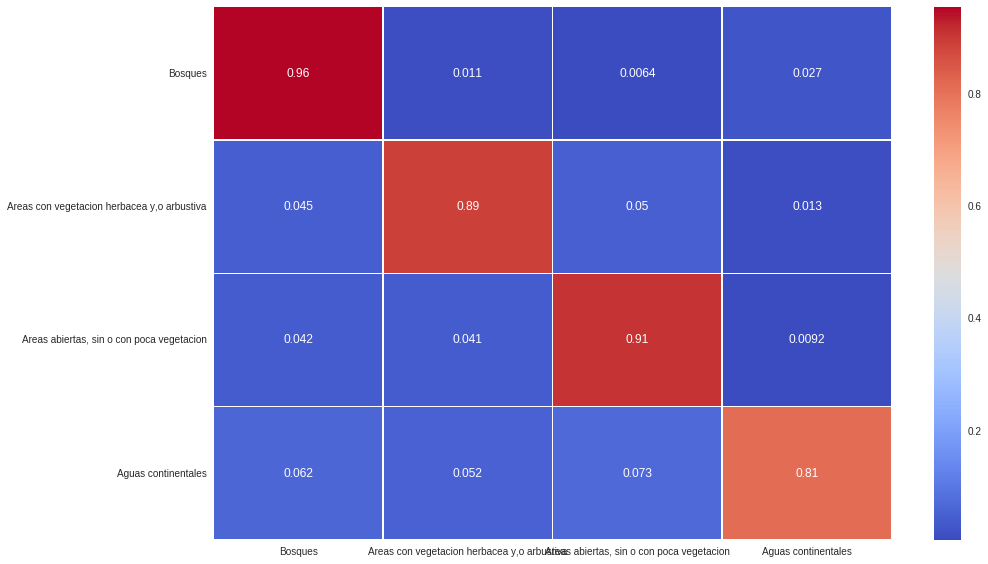

In [13]:

p=accuracy2('/media/gitecx/Nuevo vol/ASIAlac/Modelos/borrar/22/33/44/55/TOA_55',
            5692,True)

In [14]:

p=accuracy2('/media/gitecx/Nuevo vol/ASIAlac/Modelos/borrar/22/33/44/55/TOA_55',
           21584,False)

Model successfully restored
sklearn martix
[[61691  1445    15  2448]
 [  142 31438  2783  6479]
 [    0   247   939  1542]
 [    0     0     0   399]]
test accuracy 0.763595240379
[[ 0.94   0.022  0.     0.037]
 [ 0.003  0.77   0.068  0.159]
 [ 0.     0.091  0.344  0.565]
 [ 0.     0.     0.     1.   ]]


In [15]:
continue_training('/media/gitecx/Nuevo vol/ASIAlac/Modelos/borrar/22/33/44/55/TOA_55',
                  51243,5692,66)

Model successfully restored
time this epoch= 0.104253
test accuracy 0.892371026713
time this epoch= 0.095827
test accuracy 0.897800927313
time this epoch= 0.100055
test accuracy 0.897263345942
time this epoch= 0.100659
test accuracy 0.897022697937
time this epoch= 0.104388
test accuracy 0.898955428905
time this epoch= 0.106409
test accuracy 0.900351249414
time this epoch= 0.097384
test accuracy 0.902538864767
time this epoch= 0.102062
test accuracy 0.900493202158
[[1347   14    8   39]
 [  56 1270   65   17]
 [  58   58 1279    6]
 [  84   66   90 1175]]
[[ 0.957  0.01   0.006  0.028]
 [ 0.04   0.902  0.046  0.012]
 [ 0.041  0.041  0.913  0.004]
 [ 0.059  0.047  0.064  0.83 ]]
model saved as /media/gitecx/Nuevo vol/ASIAlac/Modelos/borrar/22/33/44/55/66/TOA_66
variables saved B_6_c1_128_c2_256_fc_1024_learning_rate_1e-05_dropout_0.75_decay_0.96_epsilon_1e-08_bath_512_ep_66.ckpt


Model successfully restored
sklearn martix
test accuracy 0.903301716201
[[ 0.958  0.01   0.005  0.028]
 [ 0.037  0.909  0.042  0.012]
 [ 0.039  0.041  0.914  0.006]
 [ 0.059  0.045  0.064  0.832]]


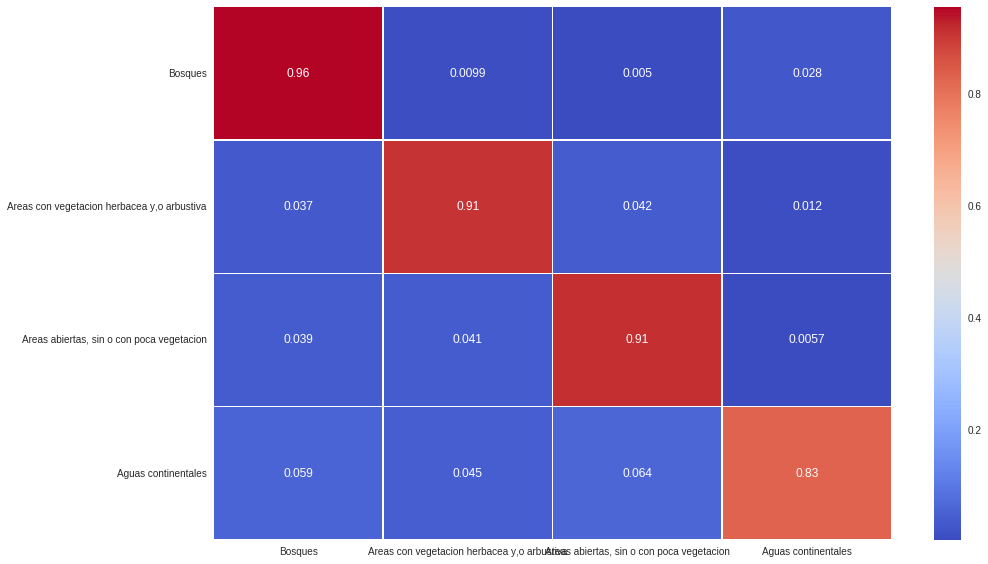

In [16]:
p=accuracy2('/media/gitecx/Nuevo vol/ASIAlac/Modelos/borrar/22/33/44/55/66/TOA_66',
            5692,True)

Model successfully restored
sklearn martix
[[61943  1558     5  2150]
 [  150 29315  7357  3959]
 [    0   196  1864   679]
 [    0     0     0   392]]
test accuracy 0.835706916385
[[ 0.943  0.024  0.     0.033]
 [ 0.004  0.719  0.18   0.097]
 [ 0.     0.072  0.681  0.248]
 [ 0.     0.     0.     1.   ]]


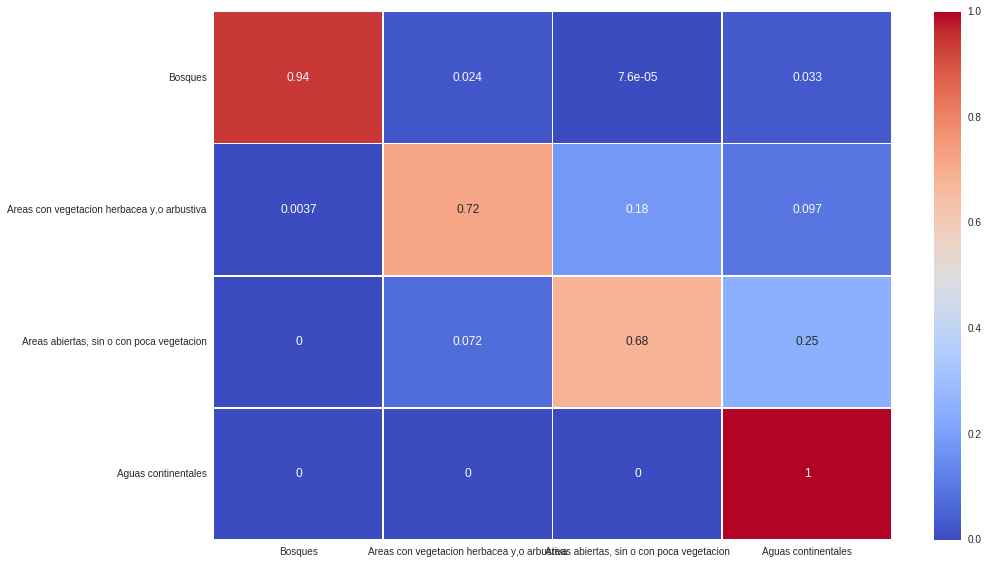

In [17]:
p=accuracy2('/media/gitecx/Nuevo vol/ASIAlac/Modelos/borrar/22/33/44/55/66/TOA_66',
           21584,False)

In [13]:
continue_training('/media/gitecx/Nuevo vol/ASIAlac/Modelos/borrar/22/33/44/55/66/TOA_66',
                  51243,5692,77)

Model successfully restored
time this epoch= 0.096962
test accuracy 0.900200750257
time this epoch= 0.098471
test accuracy 0.901377527105
time this epoch= 0.096711
test accuracy 0.901466107076
time this epoch= 0.099458
test accuracy 0.902639951443
time this epoch= 0.098126
test accuracy 0.90412376285
time this epoch= 0.103851
test accuracy 0.904060784192
time this epoch= 0.102078
test accuracy 0.905950675493
time this epoch= 0.099179
test accuracy 0.907125557681
[[1340   19   15   32]
 [  39 1318   41   13]
 [  50   61 1287   10]
 [  91   65   87 1164]]
[[ 0.953  0.014  0.011  0.023]
 [ 0.028  0.934  0.029  0.009]
 [ 0.036  0.043  0.914  0.007]
 [ 0.065  0.046  0.062  0.827]]
model saved as /media/gitecx/Nuevo vol/ASIAlac/Modelos/borrar/22/33/44/55/66/77/TOA_77
variables saved B_6_c1_128_c2_256_fc_1024_learning_rate_1e-05_dropout_0.75_decay_0.96_epsilon_1e-08_bath_512_ep_77.ckpt


Model successfully restored
sklearn martix
test accuracy 0.906881538893
[[ 0.953  0.014  0.011  0.022]
 [ 0.027  0.934  0.03   0.009]
 [ 0.036  0.044  0.913  0.007]
 [ 0.064  0.047  0.062  0.827]]


/home/gitecx/anaconda2/envs/tensorflow/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


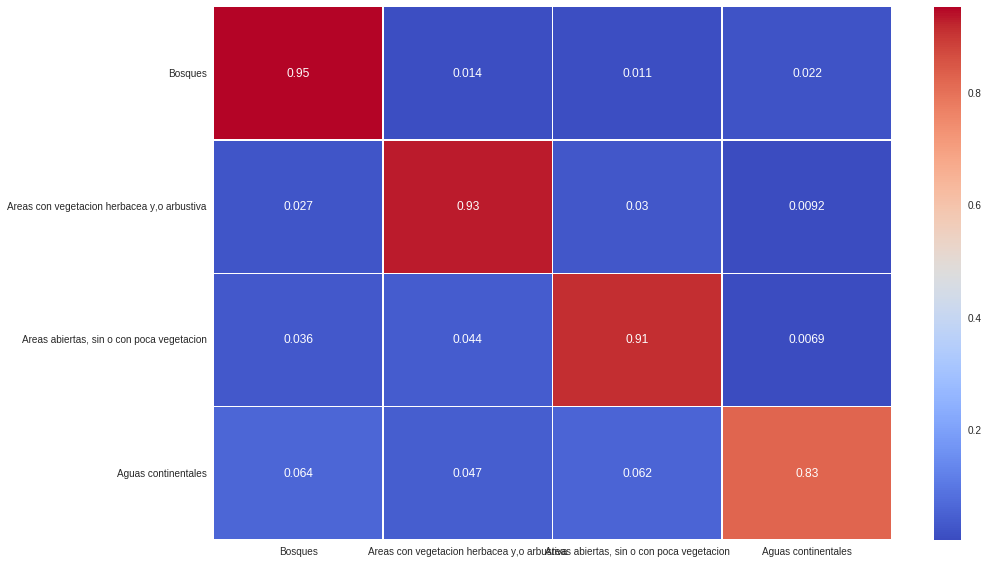

In [14]:
p=accuracy2('/media/gitecx/Nuevo vol/ASIAlac/Modelos/borrar/22/33/44/55/66/77/TOA_77',
            5692,True)

Model successfully restored
sklearn martix
[[62098  1749     5  1804]
 [  209 28029  9991  2558]
 [    0   169  2274   286]
 [    0     0     0   396]]
test accuracy 0.866571243339
[[ 0.946  0.027  0.     0.027]
 [ 0.005  0.687  0.245  0.063]
 [ 0.     0.062  0.833  0.105]
 [ 0.     0.     0.     1.   ]]


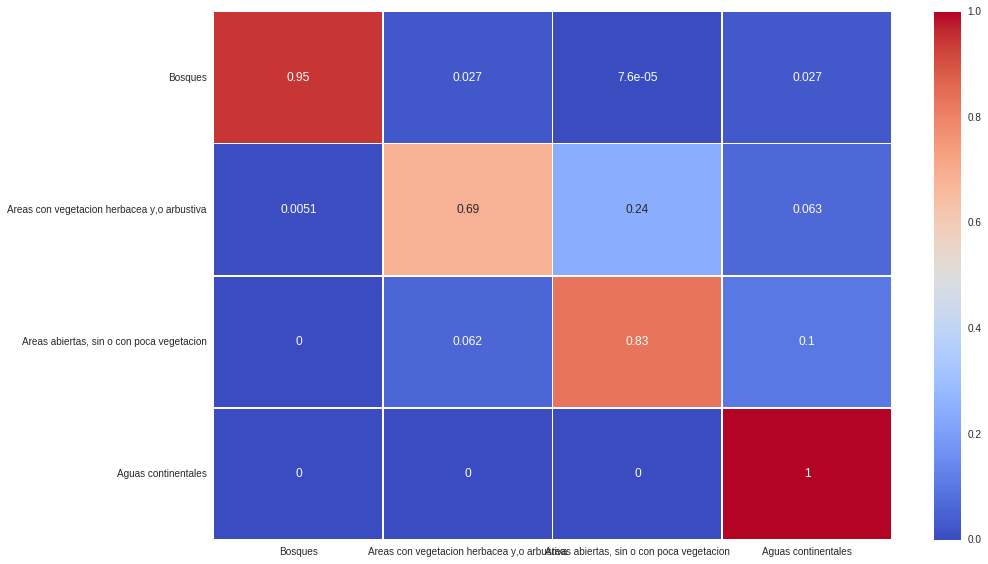

In [15]:
p=accuracy2('/media/gitecx/Nuevo vol/ASIAlac/Modelos/borrar/22/33/44/55/66/77/TOA_77',
           21584,False)